In [1]:
# https://people.brandeis.edu/~blebaron/classes/fin250a/regression/armax.html
# http://r-statistics.co/Time-Series-Analysis-With-R.html
library(forecast)
library(tidyverse) # tidy data

library(tseries)
library(MTS)

library(tsDyn)

library(vars) # post-estimation procedures to ensure adequacy of model
library(urca)
library(mFilter)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘strucchange’


The following object is masked from ‘package:stringr’:

    boundary


Loading required package: urca

Loading required package: lm

# Lagged Timeseries Analysis
- the cross-correlation
- the leading variable
- the lag

# VECM
For the sake of demonstration purposes, one county selected at random will be used to demonstrate these concepts.

In [2]:
# generate a random number between 1 and 817
sample(0:1191, 1) #400

[1] 797

# VECM (Vector Error Correction Method)
The Coaint-Johansen test tests for co-integration. This would indicate that a linear combination of non-stationary variables could potentially be stationary. Co-integration is determined using the Coaint-Johansen or the Engle-Granger tests. These tests are applied to the original timeseries, rather than to a timeseries first difference. 
The Coaint-Johansen test or test for co-integration seeks to identify if long-run relationships exist between series, and if so, identifies how many there are. If there is a co-integrating relationship, construct a VECM.VECM produces more efficient coefficient estimates than the next process, VAR. 

In [3]:
ts_data <- read_csv('employment_covid_mobility_ts.csv')
# drop X column
drops <- c("X")
ts_data <- ts_data[ , !(names(ts_data) %in% drops)]

New names:
* `` -> ...1

Rows: 117711 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (5): ...1, countyfips, emp_incbelowmed, new_case_rate, gps_away_from_home
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
ts_data$countyfips <- as.character(ts_data$countyfips)

Pivot the data.

In [5]:
pivot_emp <- ts_data %>%
    dplyr::select(date, countyfips, emp_incbelowmed) %>%
        pivot_wider(names_from = countyfips, values_from = emp_incbelowmed)

In [6]:
dim(pivot_emp) # 99 timesteps and 1190 counties

[1]   99 1190

In [7]:
pivot_covid <- ts_data %>%
    dplyr::select(date, countyfips, new_case_rate) %>%
        pivot_wider(names_from = countyfips, values_from = new_case_rate)

In [8]:
dim(pivot_covid) # 99 timesteps and 1190 counties

[1]   99 1190

In [9]:
pivot_mobility <- ts_data %>%
    dplyr::select(date, countyfips, gps_away_from_home) %>%
        pivot_wider(names_from = countyfips, values_from = gps_away_from_home)

## convert to timeseries

In [10]:
pivot_emp_ts <- data.frame(apply(pivot_emp[,2:1190], 2, function(x) ts(x)), check.names=FALSE)
pivot_emp_ts$date <- pivot_emp$date

In [11]:
pivot_covid_ts <- data.frame(apply(pivot_covid[,2:1085], 2, function(x) ts(x)),check.names=FALSE)
pivot_covid_ts$date <- pivot_covid$date

In [12]:
pivot_mobility_ts <- data.frame(apply(pivot_mobility[,2:1085], 2, function(x) ts(x)),check.names=FALSE)
pivot_mobility_ts$date <- pivot_mobility$date

## choose county at random

In [22]:
#choose random county and store emp timeseries to emp
emp <- pivot_emp[,140]
colnames(emp)[1] <- c("emp")

In [23]:
#choose random county and store covid timeseries to covid19
covid19 <- pivot_covid[,140]
colnames(covid19)[1] <- c("covid")

In [24]:
#choose random county and store covid timeseries to covid19
mobility <- pivot_mobility[,140]
colnames(mobility)[1] <- c("mobility")

## bind to one object

In [25]:
dset <- cbind(emp, covid19, mobility)

# using one variable to forecast another?

## OLS

In [27]:
# data prep
lm_dset <- data.frame(mobility, covid19)
row.names(lm_dset) <- pivot_emp$date

In [28]:
OLS <- lm(covid ~ mobility, data = lm_dset)
summary(OLS)


Call:
lm(formula = covid ~ mobility, data = lm_dset)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.0740  -5.6971  -0.9158   7.5917  16.0727 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   16.743      1.411  11.866  < 2e-16 ***
mobility     190.749     55.398   3.443  0.00085 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.292 on 97 degrees of freedom
Multiple R-squared:  0.1089,	Adjusted R-squared:  0.09973 
F-statistic: 11.86 on 1 and 97 DF,  p-value: 0.0008501


Here, R^2 and the F statistic measure the overall explainability of the independent variable over the dependent variable.
 - R^2 is calculated as the explained sum of squared errors divided by the total sum of squared errors. R^2 lies in between 0 and 1, and a larger R^2 indicates the dependent variable is best explained by the independent variables. 
 - F-statistic test against the join effect of the independent variables. A low p-value indicates the independent variables do not explain the dependent variable well.
 
When the t-statistic is inclued with the table printout, a good F-statistic and poor t-statistic can indicate collinearity.

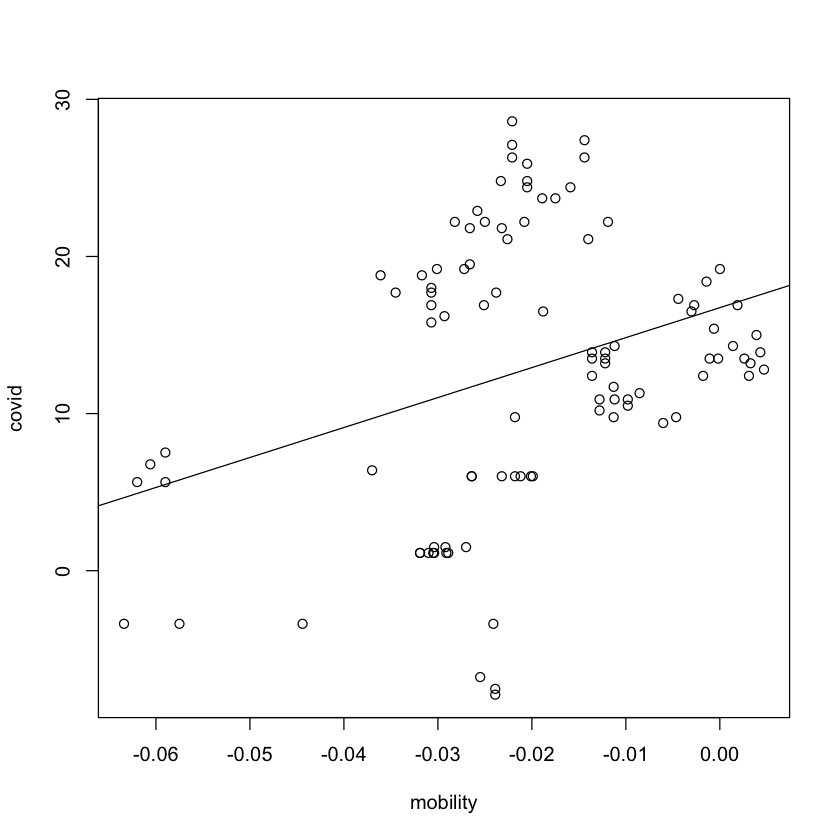

In [29]:
with(lm_dset, plot(mobility, covid))
abline(OLS)

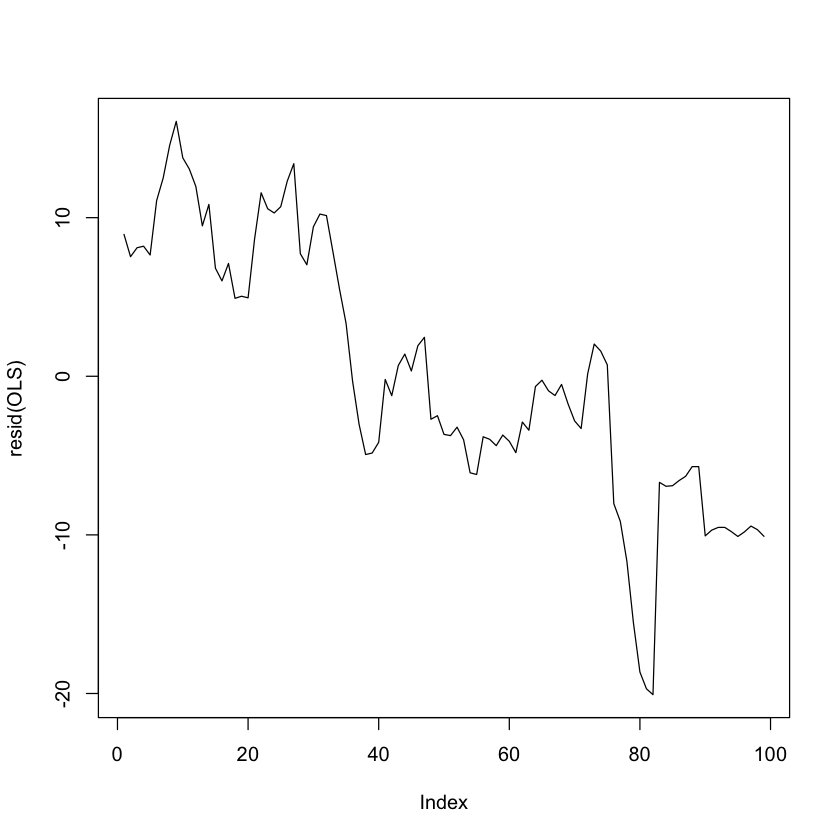

In [32]:
plot(resid(OLS), type="l")

# Build VAR to check Granger Causality (low form of causality, rather than simple correlation)
indicates usefulness, veracity in using one variable to forecast another. Can test whether mobility causes COVID or COVID causes mobility, or whether the relationship works in both directions, i.e. a unidirectional, bi-directional, or no causality.

In [42]:
# data prep
ts_data <- read_csv('employment_covid_mobility_ts_diff.csv')
# drop X column
drops <- c("X")
ts_data <- ts_data[ , !(names(ts_data) %in% drops)]
# pivot data
pivot_emp <- ts_data %>%
    dplyr::select(date, countyfips, emp_incbelowmed) %>%
        pivot_wider(names_from = countyfips, values_from = emp_incbelowmed)
pivot_covid <- ts_data %>%
    dplyr::select(date, countyfips, new_case_rate) %>%
        pivot_wider(names_from = countyfips, values_from = new_case_rate)
pivot_mobility <- ts_data %>%
    dplyr::select(date, countyfips, gps_away_from_home) %>%
        pivot_wider(names_from = countyfips, values_from = gps_away_from_home)
# convert to timeseries
pivot_emp_ts <- data.frame(apply(pivot_emp[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_emp_ts$date <- pivot_emp$date
pivot_covid_ts <- data.frame(apply(pivot_covid[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_covid_ts$date <- pivot_covid$date
pivot_mobility_ts <- data.frame(apply(pivot_mobility[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_mobility_ts$date <- pivot_mobility$date
#choose random county and store emp timeseries to emp
emp <- pivot_emp[,140]
colnames(emp)[1] <- c("emp")
covid <- pivot_covid[,140]
colnames(covid)[1] <- c("covid")
mobility <- pivot_mobility[,140]
colnames(mobility)[1] <- c("mobility")

New names:
* `` -> ...1

Rows: 78094 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): ...1, countyfips, gps_away_from_home, gps_diff, emp_incbelowmed, e...
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [43]:
dset_vars <- cbind(emp, covid, mobility)

In [58]:
model <- VAR(dset_vars, p = 22, type="const")

In [59]:
grangerCOVID <- causality(model, cause = 'mobility')

In [60]:
grangerCOVID

$Granger

	Granger causality H0: mobility do not Granger-cause emp covid

data:  VAR object model
F-Test = 2.8092, df1 = 44, df2 = 21, p-value = 0.006377


$Instant

	H0: No instantaneous causality between: mobility and emp covid

data:  VAR object model
Chi-squared = 9.6304, df = 2, p-value = 0.008106



## ACF -- is a correlation of the timeseries with lags of itself
Shows if the previous states of the time series has influence on the current state. Where the autocorrelation crosses the dashed blue line, the lag is significantly correlated. 
It can therefore be used not only to determine significant lags, but can also determine if the time series is stationary. A stationary time series will have the autocorrelation fall to zero fairly quickly. Non-stationary series drop gradually.

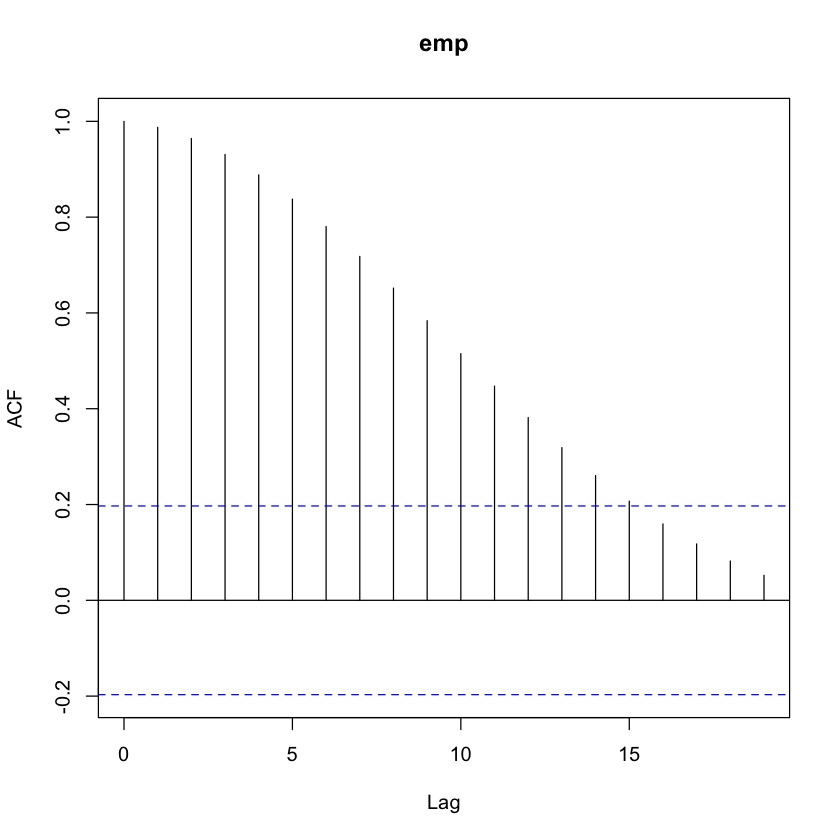

In [33]:
acf(emp)

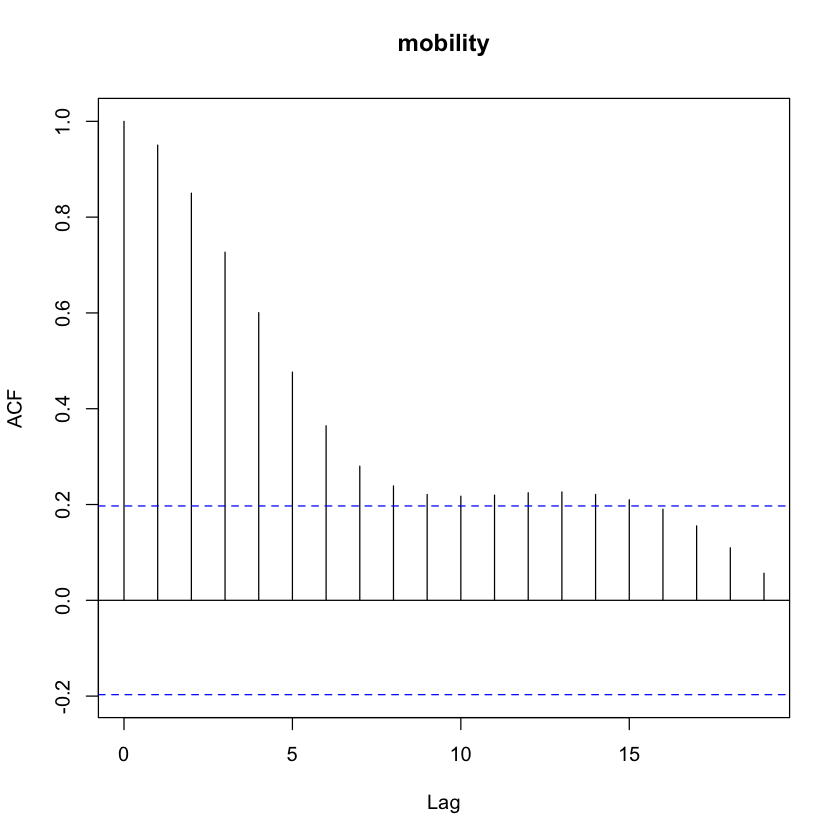

In [34]:
acf(mobility)

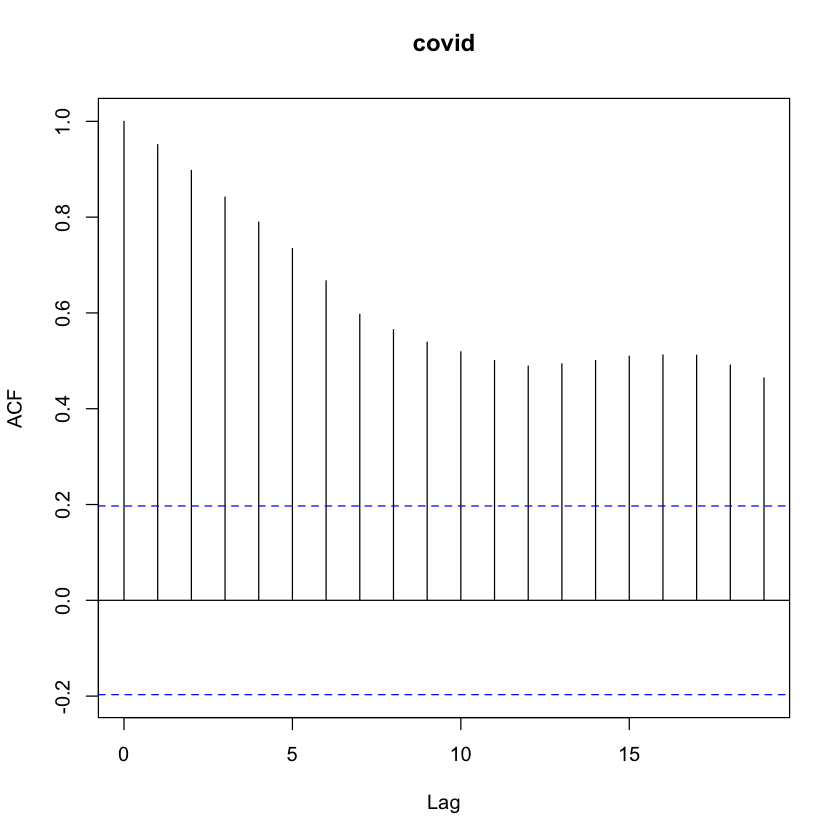

In [36]:
acf(covid19)

## PACF -- Partial Autocorrelation -- is a correlation of the time series with a lag of itself, with the linear dependence of all the lags between them removed.

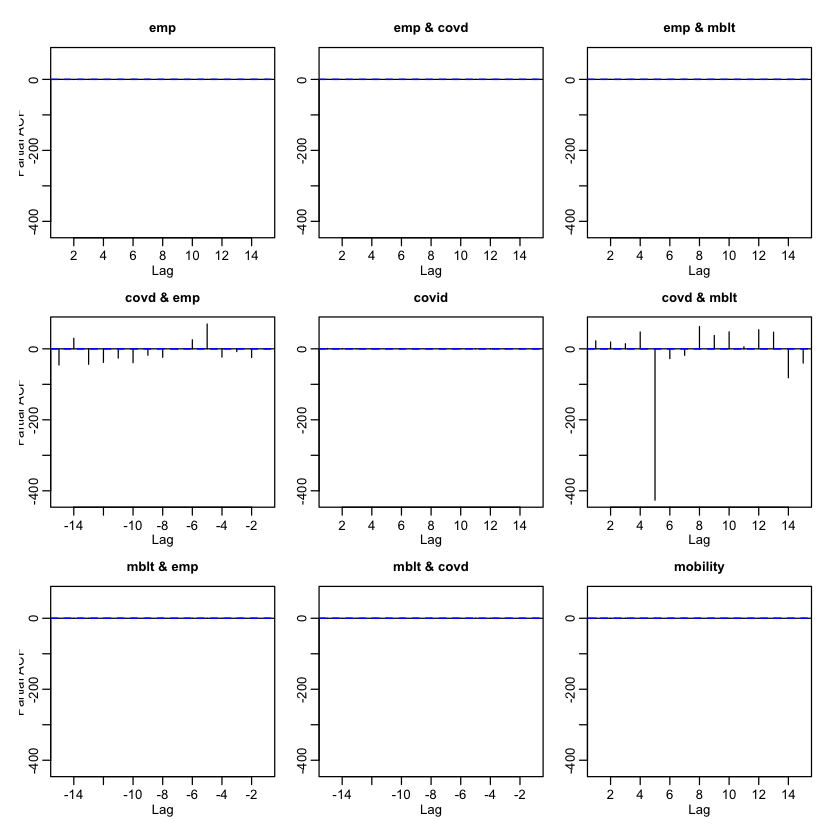

In [31]:
pacf(dset)

# test for lag selection // determine lag length
 - use VARselect
 - estimate VAR in levels and choose lag specification that minimizes the information criterion

## without linear trend

In [ ]:
ctest.nonlinear <- urca::ca.jo(dset, 
                               type ='trace', 
                               ecdet = "const", 
                    K = 23, 
                    season = NULL) # accounts for model intercepts
summary(ctest.nonlinear)

## with linear trend

In [ ]:
ctest.linear <- ca.jo(dset, ecdet = "none", type = "trace", K = 23, season = NULL)
summary(ctest.linear)

## Build VAR

In [21]:
nonlinear.model = VECM(dset, 23, r=2, estim=("ML"))
VARmodel.nonlinear <- vec2var(nonlinear.model, r=2)

In [ ]:
linear.model = VECM(dset, 23, r=3, estim=("ML"))
VARmodel.linear <- vec2var(linear.model, r=3)

# check validty of model
p-value for Ljung-Box statistic
Q-Q plot
serial durbin

In [61]:
serial.test(model, lags.pt = 22, type = 'PT.asymptotic')


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model
Chi-squared = 322.8, df = 0, p-value < 2.2e-16

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model
Chi-squared = 322.8, df = 0, p-value < 2.2e-16



In [ ]:
# arch effects would indicate clustered volatility in the model